In [2]:
#Import Libraries
import csv
import tweepy
from dotenv import dotenv_values

import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

from tqdm.notebook import tqdm

import re
import string

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# 2.1 - Twitter API

This section shows the attempt at using Twitter API to collect data

In [15]:
#pip install tweepy

In [16]:
config = dotenv_values(".env")

In [17]:
accessToken = config["ACCESS_TOKEN"]
accessTokenSecret = config["ACCESS_TOKEN_SECRET"]
apiKey = config["API_KEY"]
apiSecret = config["API_KEY_SECRET"]
bearerToken = config["BEARER_TOKEN"]

My keys are stored in a seperate .env for security reasons

In [19]:
#apiKey

In [18]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(apiKey, apiSecret) #API Keys
auth.set_access_token(accessToken, accessTokenSecret) #Access tokens

In [24]:
# Create API object
api = tweepy.API(auth, wait_on_rate_limit=True)

In [25]:
# Define the search query and date range
query = "Ronnie O'Sullivan OR #RonnieOSullivan -filter:retweets" #Search his name or hashtag of it
startDate = "2022-01-01"
endDate = "2022-12-31"

In [26]:
# Iterate through pages of results and save to CSV file
csvFile = open("ronnieTweets.csv", "w") #Name of file and write mode
csvWriter = csv.writer(csvFile)

for page in tweepy.Cursor(api.search_tweets, q=query, lang="en", since_id=startDate, until=endDate).pages():
    for tweet in page:
        csvWriter.writerow([tweet.id, tweet.created_at, tweet.text])
        
csvFile.close()

Forbidden: 403 Forbidden
453 - You currently have Essential access which includes access to Twitter API v2 endpoints only. If you need access to this endpoint, you’ll need to apply for Elevated access via the Developer Portal. You can learn more here: https://developer.twitter.com/en/docs/twitter-api/getting-started/about-twitter-api#v2-access-leve

Twitter v2 endpoints only allow someone to search for recent tweets. Unsuitable for this project

In [28]:
import requests
import json
from twitter_stream import FilteredStream

In [33]:
search_url = "https://api.twitter.com/2/tweets/search/recent"

query_params = {
    #Escaping the character \\"
    "query" : "\"Ronnie O'Sullivan\" -is:retweet",
    "max_results" : "100",
    "tweet.fields" : "author_id",
    "user.fields" : "name"
}

def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {bearerToken}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url,params):
    response = requests.get(url,auth=bearer_oauth,params=params)#
    return response.json()

json_response = connect_to_endpoint(search_url, query_params)

parsedRes = json.dumps(json_response, indent=4, ensure_ascii=False)
print(parsedRes)

{
    "data": [
        {
            "text": "Ronnie O'Sullivan wordt door velen als de \"Greatest Of All Time\" beschouwd en behaalde in 2022 zijn zevende wereldtitel, waarmee hij op gelijke hoogte als Stephen Hendry kwam. Toch mocht ook dat niet baten, want zowel in 2020 als in 2022 landde hij buiten de top 3.",
            "author_id": "2256824641",
            "id": "1653736033521917953",
            "edit_history_tweet_ids": [
                "1653736033521917953"
            ]
        },
        {
            "text": "Die eerste plaats was voor Steve Davis in 1988. De laatste keer dat snooker in de top 3 is geëindigd dateert van 1990: een tweede plaats voor Stephen Hendry. In 2020 en 2022 was Ronnie O'Sullivan genomineerd.",
            "author_id": "2256824641",
            "id": "1653736028430057473",
            "edit_history_tweet_ids": [
                "1653736028430057473"
            ]
        },
        {
            "text": "@sporza Hij staat op nummer 2 in de wereld. 

Lifted this code from my CA2 in first semester. Based on code in one of Sam's class. 100 tweets is the max I can get. Downloading from archive.org also not doable due to the sheer volume of it all. 

# 2.2 EDA

The datasets are carried over from the other notebook included after Big Data Preprocessing

In [9]:
yearlyTweets = pd.read_csv("YearCount.csv")

In [11]:
yearlyTweets

,Unnamed: 0,Year,count
0,0,2010,1
1,1,2011,44
2,2,2012,316
3,3,2013,478
4,4,2014,232
5,5,2015,436
6,6,2016,935
7,7,2017,377


In [12]:
yearlyTweets = yearlyTweets.drop("Unnamed: 0", axis=1)

Text(0, 0.5, 'Tweets Per Year')

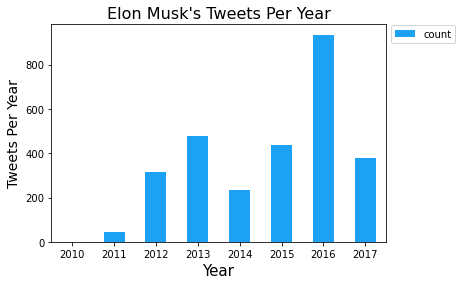

In [19]:
ax1 = yearlyTweets.plot(x="Year",
                y="count",
                kind="bar",
                rot=0,#1DA1F2
                color="#1DA1F2")
ax1.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.title("Elon Musk's Tweets Per Year", fontsize=16)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Tweets Per Year", fontsize = 14)

I have tweets for years 2010 to 2017. I opted to go for 2016 due to it having the most tweets per year.<br>
More tweets should maximise the chances of the forecasting performing well

# 2.3 Preperation for Machine Learning
This section is for how we prepare the data for forecasting. This will include sanitising the tweets, extracting the sentiment value and filling in missing dates

In [30]:
data = pd.read_csv("2016tweets.csv")

In [31]:
data.head()

,Unnamed: 0,date,text
0,0,2016-12-31 21:30:05,b'HW2 Autopilot software uploading to 1000 car...
1,1,2016-12-31 02:47:28,"b'@vicentes @DragTimes Late Jan, along with Li..."
2,2,2016-12-31 02:40:28,"b'@DragTimes Yes, but held up by Autopilot . I..."
3,3,2016-12-31 02:34:09,b'Resolving an Autopilot HW2 bug that shows up...
4,4,2016-12-30 19:44:02,b'Churchill (non) quotes \nhttps://t.co/avA4YD...


In [32]:
data = data.drop("Unnamed: 0", axis=1) #Get rid of Unnamed

In [33]:
data.head()

,date,text
0,2016-12-31 21:30:05,b'HW2 Autopilot software uploading to 1000 car...
1,2016-12-31 02:47:28,"b'@vicentes @DragTimes Late Jan, along with Li..."
2,2016-12-31 02:40:28,"b'@DragTimes Yes, but held up by Autopilot . I..."
3,2016-12-31 02:34:09,b'Resolving an Autopilot HW2 bug that shows up...
4,2016-12-30 19:44:02,b'Churchill (non) quotes \nhttps://t.co/avA4YD...


In [34]:
data["date"]

0      2016-12-31 21:30:05
1      2016-12-31 02:47:28
2      2016-12-31 02:40:28
3      2016-12-31 02:34:09
4      2016-12-30 19:44:02
              ...         
930    2016-01-10 20:11:38
931    2016-01-10 20:08:28
932    2016-01-10 20:04:43
933    2016-01-02 17:07:03
934    2016-01-01 00:19:43
Name: date, Length: 935, dtype: object

In [35]:
data.dtypes #Check types

date    object
text    object
dtype: object

In [40]:
data=data.rename(columns={"date":"Date","text": "Text"}) #Rename column
data["Date"]=pd.to_datetime(data["Date"],format="%Y/%m/%d")#Change to datetime

In [41]:
data.head()

,Date,Text
0,2016-12-31 21:30:05,b'HW2 Autopilot software uploading to 1000 car...
1,2016-12-31 02:47:28,"b'@vicentes @DragTimes Late Jan, along with Li..."
2,2016-12-31 02:40:28,"b'@DragTimes Yes, but held up by Autopilot . I..."
3,2016-12-31 02:34:09,b'Resolving an Autopilot HW2 bug that shows up...
4,2016-12-30 19:44:02,b'Churchill (non) quotes \nhttps://t.co/avA4YD...


In [42]:
data.dtypes

Date    datetime64[ns]
Text            object
dtype: object

In [43]:
data.tail()

,Date,Text
930,2016-01-10 20:11:38,"b""In ~2 years, summon should work anywhere con..."
931,2016-01-10 20:08:28,b'Tap your phone or key and your car will open...
932,2016-01-10 20:04:43,b'First baby step in Tesla Summon capability n...
933,2016-01-02 17:07:03,"b'Worth reading The Machine Stops, an old stor..."
934,2016-01-01 00:19:43,b'Falcon 9 back in the hangar at Cape Canavera...


In [45]:
data.Text[0]

"b'HW2 Autopilot software uploading to 1000 cars this eve. Will then hold to verify no field issues and upload to rest of fleet next week.'"

In [46]:
data.Text[89]

"b'RT @ggreenwald: Trump Picks Top Climate Skeptic to Lead EPA Transition https://t.co/fTiN4KuKJq'"

In [48]:
sia = SentimentIntensityAnalyzer()

In [50]:
X = data.Text

In [51]:
X

0      b'HW2 Autopilot software uploading to 1000 car...
1      b'@vicentes @DragTimes Late Jan, along with Li...
2      b'@DragTimes Yes, but held up by Autopilot . I...
3      b'Resolving an Autopilot HW2 bug that shows up...
4      b'Churchill (non) quotes \nhttps://t.co/avA4YD...
                             ...                        
930    b"In ~2 years, summon should work anywhere con...
931    b'Tap your phone or key and your car will open...
932    b'First baby step in Tesla Summon capability n...
933    b'Worth reading The Machine Stops, an old stor...
934    b'Falcon 9 back in the hangar at Cape Canavera...
Name: Text, Length: 935, dtype: object

In [53]:
# Store the stopwords into the object named as "stop_words"
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()

In [54]:
cleaned_data=[]

# For loop from first value to length(X), ^a-zA-Z means include small and capital case letters

for i in range(len(X)):
    tweet = re.sub('[^a-zA-Z]', ' ', X.iloc[i])
    tweet = tweet.lower().split()
    tweet = [stemmer.stem(word) for word in tweet if (word not in stop_words) and (word not in punct)]
    tweet = ' '.join(tweet)
    cleaned_data.append(tweet)

Based on one of Muhammad's classes from last semester

In [55]:
cleaned_data

['b hw autopilot softwar upload car eve hold verifi field issu upload rest fleet next week',
 'b vicent dragtim late jan along linux kernel upgrad',
 'b dragtim ye held autopilot def work tho shave sec mph amp mile ap goe xe x xa http co kbv qgc',
 'b resolv autopilot hw bug show boot subzero cold soak fix work softwar start upload tmrw',
 'b churchil non quot nhttp co ava yd k g',
 'b rt iridiumcomm mileston alert first ten iridiumnext satellit stack encapsul falcon fair nextevolutio xe x xa',
 'b andrewket almost undergo final valid might go next day',
 'b rt electrekco tesla autopilot xe x x new radar technolog predict accid caught dashcam second later http co f ndvsg hx http xe x xa',
 'b deu ex machina center screen end',
 'b quipm occasion existenti dread inevit think futur',
 'b djsearl fredericlambert ye grid need moder use supercharg non snowi region',
 'b fredericlambert mere kw refer children toy',
 'b yamenalhaddad brain full right hard one',
 'b fredericlambert instal alre

In [57]:
data["Cleaned"] = cleaned_data

In [58]:
data.head()

,Date,Text,Cleaned
0,2016-12-31 21:30:05,b'HW2 Autopilot software uploading to 1000 car...,b hw autopilot softwar upload car eve hold ver...
1,2016-12-31 02:47:28,"b'@vicentes @DragTimes Late Jan, along with Li...",b vicent dragtim late jan along linux kernel u...
2,2016-12-31 02:40:28,"b'@DragTimes Yes, but held up by Autopilot . I...",b dragtim ye held autopilot def work tho shave...
3,2016-12-31 02:34:09,b'Resolving an Autopilot HW2 bug that shows up...,b resolv autopilot hw bug show boot subzero co...
4,2016-12-30 19:44:02,b'Churchill (non) quotes \nhttps://t.co/avA4YD...,b churchil non quot nhttp co ava yd k g


In [59]:
def get_sentiment(text):
    sentiment = sia.polarity_scores(text) #Sentiment is polarity score of text
    return sentiment['compound'] #Function returns compound score

In [60]:
data['Sentiment'] = data['Cleaned'].apply(get_sentiment) #New column will be text from Cleaned applied to above function

In [61]:
data.head()

,Date,Text,Cleaned,Sentiment
0,2016-12-31 21:30:05,b'HW2 Autopilot software uploading to 1000 car...,b hw autopilot softwar upload car eve hold ver...,0.0
1,2016-12-31 02:47:28,"b'@vicentes @DragTimes Late Jan, along with Li...",b vicent dragtim late jan along linux kernel u...,0.0
2,2016-12-31 02:40:28,"b'@DragTimes Yes, but held up by Autopilot . I...",b dragtim ye held autopilot def work tho shave...,0.0
3,2016-12-31 02:34:09,b'Resolving an Autopilot HW2 bug that shows up...,b resolv autopilot hw bug show boot subzero co...,0.0
4,2016-12-30 19:44:02,b'Churchill (non) quotes \nhttps://t.co/avA4YD...,b churchil non quot nhttp co ava yd k g,0.0


In [62]:
data.tail() #Seeing nothing but zeros had me worried so I checked the tail too2

,Date,Text,Cleaned,Sentiment
930,2016-01-10 20:11:38,"b""In ~2 years, summon should work anywhere con...",b year summon work anywher connect land amp bl...,-0.4404
931,2016-01-10 20:08:28,b'Tap your phone or key and your car will open...,b tap phone key car open garag door exit close...,0.0000
932,2016-01-10 20:04:43,b'First baby step in Tesla Summon capability n...,b first babi step tesla summon capabl download...,0.0000
933,2016-01-02 17:07:03,"b'Worth reading The Machine Stops, an old stor...",b worth read machin stop old stori e forster h...,-0.0772
934,2016-01-01 00:19:43,b'Falcon 9 back in the hangar at Cape Canavera...,b falcon back hangar cape canaver damag found ...,-0.3400


In [63]:
#data.to_csv('CleanedTweets.csv', index=False)

In [64]:
#data = pd.read_csv("CleanedTweets.csv")

In [3]:
data.head()

,date,text,Cleaned,Sentiment
0,2016-12-31 21:30:05,b'HW2 Autopilot software uploading to 1000 car...,b hw autopilot softwar upload car eve hold ver...,0.0
1,2016-12-31 02:47:28,"b'@vicentes @DragTimes Late Jan, along with Li...",b vicent dragtim late jan along linux kernel u...,0.0
2,2016-12-31 02:40:28,"b'@DragTimes Yes, but held up by Autopilot . I...",b dragtim ye held autopilot def work tho shave...,0.0
3,2016-12-31 02:34:09,b'Resolving an Autopilot HW2 bug that shows up...,b resolv autopilot hw bug show boot subzero co...,0.0
4,2016-12-30 19:44:02,b'Churchill (non) quotes \nhttps://t.co/avA4YD...,b churchil non quot nhttp co ava yd k g,0.0


In [69]:
dateRange = pd.date_range(start="2016-01-01", end="2016-12-31") #Defining range from start of 2016 to end

In [70]:
averageSentiment = data.groupby(data['Date'].dt.date)['Sentiment'].mean() #Use Groupby to get a daily averge

In [66]:
startDate = data['Date'].min().date() 
endDate = data['Date'].max().date()
dateRange = pd.date_range(start=startDate, end=endDate, freq='D')

In [67]:
startDate

datetime.date(2016, 1, 1)

In [71]:
#Puts dates in order and fills in missing days
averageSentiment = averageSentiment.reindex(dateRange)

In [72]:
averageSentiment

2016-01-01   -0.340000
2016-01-02   -0.077200
2016-01-03         NaN
2016-01-04         NaN
2016-01-05         NaN
                ...   
2016-12-27    0.000000
2016-12-28         NaN
2016-12-29         NaN
2016-12-30    0.180767
2016-12-31    0.000000
Freq: D, Name: Sentiment, Length: 366, dtype: float64

In [73]:
averageSentiment = averageSentiment.fillna(0) #Fill missing days with zeros

In [76]:
averageSentiment

2016-01-01   -0.340000
2016-01-02   -0.077200
2016-01-03    0.000000
2016-01-04    0.000000
2016-01-05    0.000000
                ...   
2016-12-27    0.000000
2016-12-28    0.000000
2016-12-29    0.000000
2016-12-30    0.180767
2016-12-31    0.000000
Freq: D, Name: Sentiment, Length: 366, dtype: float64

In [80]:
avgSentimentDf = averageSentiment.to_frame(name='average_sentiment').reset_index() #Converting to dataframe

In [81]:
avgSentimentDf.head()

,index,average_sentiment
0,2016-01-01,-0.3400
1,2016-01-02,-0.0772
2,2016-01-03,0.0000
3,2016-01-04,0.0000
4,2016-01-05,0.0000


In [17]:
avgSentimentDf = avgSentimentDf.rename(columns={'index': 'Date', 'average_sentiment': 'Sentiment'}) #Rename columns

In [18]:
avgSentimentDf.head() #Check that is works

,Date,Sentiment
0,2016-01-01,-0.3400
1,2016-01-02,-0.0772
2,2016-01-03,0.0000
3,2016-01-04,0.0000
4,2016-01-05,0.0000


In [19]:
#avgSentiment.to_csv('AverageSentiment.csv', index=False) #Write to csv to save my progress

# 2.4 Forecasting
Now that data is ready, we can start forecasting

In [134]:
data = pd.read_csv("AverageSentiment.csv")

In [135]:
data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d")

# Set the date column as the index of the dataframe
data.set_index('Date', inplace=True)
data=data.asfreq("D")
data=data.sort_index()

In [136]:
data.head()

,Sentiment
Date,
2016-01-01,-0.3400
2016-01-02,-0.0772
2016-01-03,0.0000
2016-01-04,0.0000
2016-01-05,0.0000


In [137]:
data.dtypes #Check types to see if datetime stuck or not

Sentiment    float64
dtype: object

In [138]:
steps=round(366*0.2)

In [139]:
steps=round(366*0.2) #Test/train split 80/20. 2016 was a leap year
data_train=data[:-steps] #End of data - split
data_test=data[-steps:] #Take away steps from the end

In [140]:
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2016-01-01 00:00:00 --- 2016-10-19 00:00:00  (n=293)
Test dates  : 2016-10-20 00:00:00 --- 2016-12-31 00:00:00  (n=73)


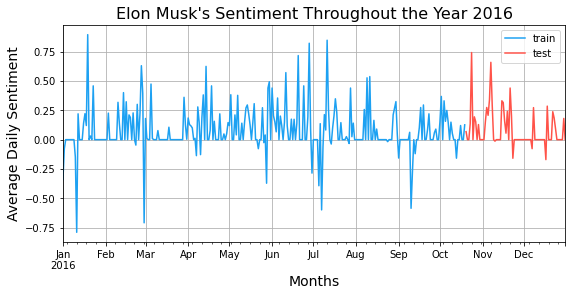

In [141]:
fig, ax=plt.subplots(figsize=(9,4))
data_train['Sentiment'].plot(ax=ax, label='train', color="#1DA1F2")
data_test['Sentiment'].plot(ax=ax, label="test", color="#ff5349")
plt.title("Elon Musk's Sentiment Throughout the Year 2016", fontsize=16)
plt.xlabel("Months", fontsize=14)
plt.ylabel("Average Daily Sentiment", fontsize = 14)
plt.grid(True)
ax.legend();

In [142]:
forecaster = ForecasterAutoreg(
regressor=RandomForestRegressor(random_state=123),
lags=6)

In [143]:
forecaster.fit(y=data_train["Sentiment"])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-01-01 00:00:00'), Timestamp('2016-10-19 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-26 19:28:29 
Last fit date: 2023-05-26 19:28:29 
Skforecast version: 0.7.0 
Python version: 3.9.12 
Forecaster id: None 

In [144]:
predictions = forecaster.predict(steps=steps)
predictions.head()

2016-10-20    0.121193
2016-10-21    0.163981
2016-10-22    0.106451
2016-10-23    0.171392
2016-10-24    0.114855
Freq: D, Name: pred, dtype: float64

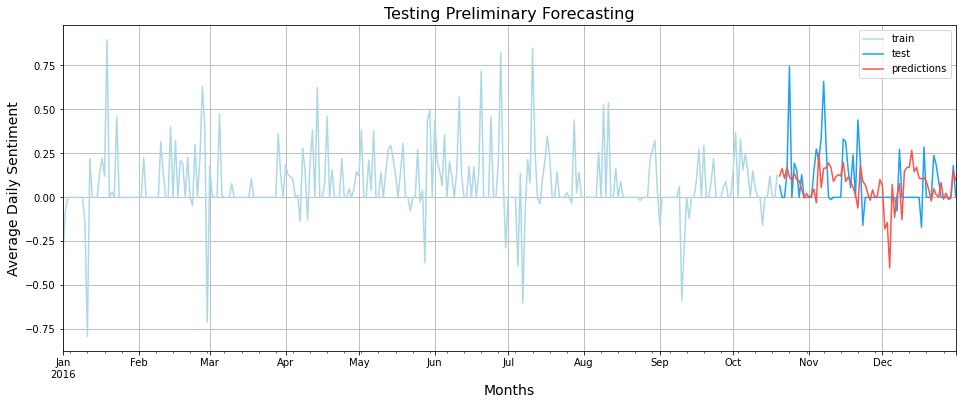

In [150]:
fig, ax = plt.subplots(figsize=(16, 6))
data_train['Sentiment'].plot(ax=ax, label='train', color="LightBlue")
data_test['Sentiment'].plot(ax=ax, label='test', color="#1DA1F2")
predictions.plot(ax=ax, label='predictions', color="#ff5349")
plt.title("Testing Preliminary Forecasting", fontsize=16)
plt.xlabel("Months", fontsize=14)
plt.ylabel("Average Daily Sentiment", fontsize = 14)
plt.grid(True)
ax.legend();

Code is heavily based on one of David's classes

# 2.5 Hyperparameter Tuning <br>
Some of my attempts at making this good. Can just scroll to the end

In [19]:
error_mse = mean_squared_error(
    y_true=data_test['Sentiment'],
    y_pred=predictions)

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.030133824103468796


In [20]:
forecaster = ForecasterAutoreg(
regressor=RandomForestRegressor(random_state=123),
lags=6)
lags_grid=[1,2,3,4,5,6] #1 through 6 day windows

param_grid={"n_estimators":[100,500,750],
           "max_depth":[3,5,10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Sentiment'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 54.


loop lags_grid: 100%|███████████████████████████████████████| 6/6 [07:07<00:00, 71.32s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.04082202364386722



In [21]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
45,"[1, 2, 3, 4, 5, 6]","{'max_depth': 3, 'n_estimators': 100}",0.040822,3,100
46,"[1, 2, 3, 4, 5, 6]","{'max_depth': 3, 'n_estimators': 500}",0.041219,3,500
47,"[1, 2, 3, 4, 5, 6]","{'max_depth': 3, 'n_estimators': 750}",0.041303,3,750
38,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 750}",0.041314,3,750
53,"[1, 2, 3, 4, 5, 6]","{'max_depth': 10, 'n_estimators': 750}",0.041364,10,750
28,"[1, 2, 3, 4]","{'max_depth': 3, 'n_estimators': 500}",0.041368,3,500
37,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 500}",0.041374,3,500
52,"[1, 2, 3, 4, 5, 6]","{'max_depth': 10, 'n_estimators': 500}",0.041376,10,500
29,"[1, 2, 3, 4]","{'max_depth': 3, 'n_estimators': 750}",0.041425,3,750
50,"[1, 2, 3, 4, 5, 6]","{'max_depth': 5, 'n_estimators': 750}",0.041433,5,750


Max depth of 3, n_estimators of 100, and lags of 6 is the best according to this

In [22]:
regressor = RandomForestRegressor(max_depth= 3, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
regressor=regressor,
lags=6)

In [23]:
forecaster.fit(y=data_train["Sentiment"])

In [24]:
predictions=forecaster.predict(steps=steps)

In [25]:
predictions

2016-10-20    0.067125
2016-10-21    0.069196
2016-10-22    0.069017
2016-10-23    0.068117
2016-10-24    0.076726
                ...   
2016-12-27    0.070816
2016-12-28    0.075991
2016-12-29    0.070816
2016-12-30    0.070816
2016-12-31    0.070816
Freq: D, Name: pred, Length: 73, dtype: float64

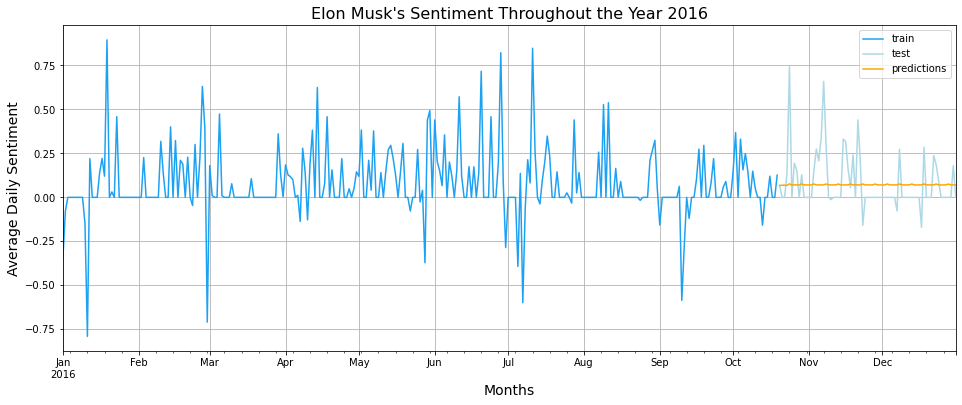

In [27]:
fig, ax = plt.subplots(figsize=(16, 6))
data_train['Sentiment'].plot(ax=ax, label='train', color="#1DA1F2")
data_test['Sentiment'].plot(ax=ax, label='test', color="LightBlue")
predictions.plot(ax=ax, label='predictions', color="Orange")
plt.title("Elon Musk's Sentiment Throughout the Year 2016", fontsize=16)
plt.xlabel("Months", fontsize=14)
plt.ylabel("Average Daily Sentiment", fontsize = 14)
plt.grid(True)
ax.legend();

Not great so I'll try other windows

In [28]:
forecaster = ForecasterAutoreg(
regressor=RandomForestRegressor(random_state=123),
lags=6)
lags_grid=[6,7,8,9,10,11,12] #6 through 12 day windows

param_grid={"n_estimators":[100,500,750],
           "max_depth":[3,5,10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Sentiment'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 63.


loop lags_grid: 100%|██████████████████████████████████████| 7/7 [27:40<00:00, 237.17s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.03968920594633687



In [29]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
51,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","{'max_depth': 10, 'n_estimators': 100}",0.039689,10,100
60,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 100}",0.040287,10,100
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'max_depth': 10, 'n_estimators': 500}",0.040328,10,500
52,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","{'max_depth': 10, 'n_estimators': 500}",0.040371,10,500
61,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 500}",0.040377,10,500
...,...,...,...,...,...
3,"[1, 2, 3, 4, 5, 6]","{'max_depth': 5, 'n_estimators': 100}",0.041641,5,100
9,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 3, 'n_estimators': 100}",0.041697,3,100
26,"[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 10, 'n_estimators': 750}",0.041834,10,750
25,"[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 10, 'n_estimators': 500}",0.041859,10,500


In [30]:
regressor = RandomForestRegressor(max_depth= 10, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
regressor=regressor,
lags=11)

In [31]:
forecaster.fit(y=data_train["Sentiment"])
predictions=forecaster.predict(steps=steps)

In [ ]:
forecaster = ForecasterAutoreg(
regressor=RandomForestRegressor(random_state=123),
lags=6)
lags_grid=[6,7,8,9,10,11,12] #6 through 12 day windows

param_grid={"n_estimators":[100,500,750],
           "max_depth":[3,5,10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Sentiment'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

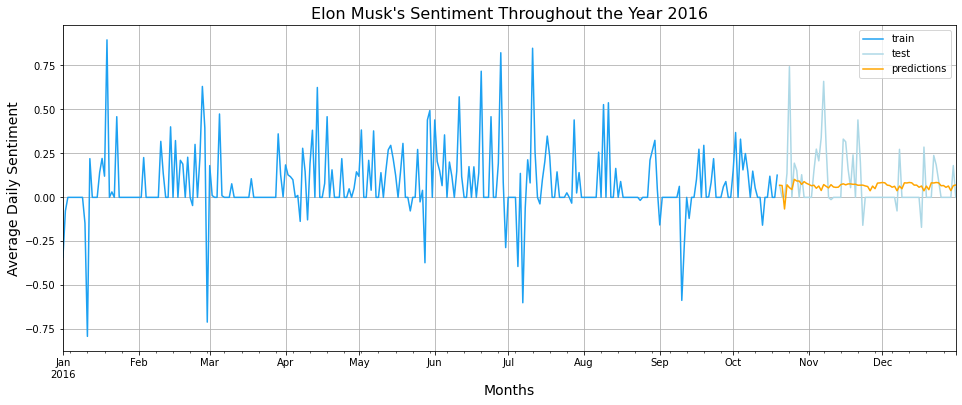

In [32]:
fig, ax = plt.subplots(figsize=(16, 6))
data_train['Sentiment'].plot(ax=ax, label='train', color="#1DA1F2")
data_test['Sentiment'].plot(ax=ax, label='test', color="LightBlue")
predictions.plot(ax=ax, label='predictions', color="Orange")
plt.title("Elon Musk's Sentiment Throughout the Year 2016", fontsize=16)
plt.xlabel("Months", fontsize=14)
plt.ylabel("Average Daily Sentiment", fontsize = 14)
plt.grid(True)
ax.legend();

In [33]:
forecaster = ForecasterAutoreg(
regressor=RandomForestRegressor(random_state=123),
lags=6)
lags_grid=[14, 31, 62] #Try fortnight, month, two months

param_grid={"n_estimators":[100,500,750],
           "max_depth":[3,5,10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Sentiment'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 27.


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [06:58<00:00, 139.60s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.040880159984670546



In [34]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 3, 'n_estimators': 500}",0.040880,3,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 3, 'n_estimators': 750}",0.040900,3,750
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 5, 'n_estimators': 100}",0.040903,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 100}",0.040932,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 3, 'n_estimators': 100}",0.040936,3,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 750}",0.040948,10,750
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 5, 'n_estimators': 500}",0.040950,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 5, 'n_estimators': 750}",0.040994,5,750
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.041050,5,500
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.041058,3,500


In [35]:
regressor = RandomForestRegressor(max_depth= 3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
regressor=regressor,
lags=14)
forecaster.fit(y=data_train["Sentiment"])
predictions=forecaster.predict(steps=steps)

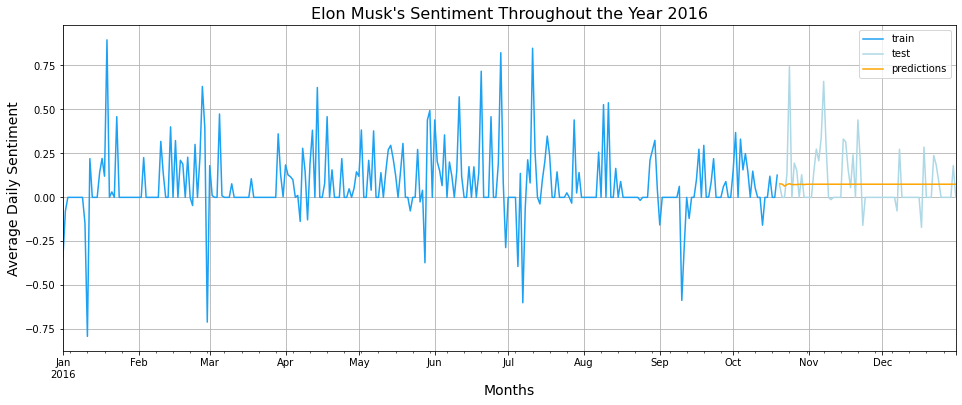

In [36]:
fig, ax = plt.subplots(figsize=(16, 6))
data_train['Sentiment'].plot(ax=ax, label='train', color="#1DA1F2")
data_test['Sentiment'].plot(ax=ax, label='test', color="LightBlue")
predictions.plot(ax=ax, label='predictions', color="Orange")
plt.title("Elon Musk's Sentiment Throughout the Year 2016", fontsize=16)
plt.xlabel("Months", fontsize=14)
plt.ylabel("Average Daily Sentiment", fontsize = 14)
plt.grid(True)
ax.legend();

The models have been getting worse. Think I struck gold with the first one. I feel like I'm missing something in my understand of this

In [38]:
forecaster = ForecasterAutoreg(
regressor=RandomForestRegressor(random_state=123),
lags=6)
lags_grid=[90] #Try three month window

param_grid={"n_estimators":[100,500,750],
           "max_depth":[3,5,10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Sentiment'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 9.


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [02:30<00:00, 150.06s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90] 
  Parameters: {'max_depth': 3, 'n_estimators': 750}
  Backtesting metric: 0.04044913970876863



Based on MSE, not much better than previous. Won't even graph it. Will look at N Estimators and call it there

In [48]:
forecaster = ForecasterAutoreg(
regressor=RandomForestRegressor(random_state=123),
lags=6)
lags_grid=[6]

param_grid={"n_estimators":[10,50,100],
           "max_depth":[3,5,10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Sentiment'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 9.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:14<00:00, 14.26s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.04069938547211199



In [44]:
regressor = RandomForestRegressor(max_depth= 5, n_estimators=50, random_state=123)
forecaster = ForecasterAutoreg(
regressor=regressor,
lags=6)
forecaster.fit(y=data_train["Sentiment"])
predictions=forecaster.predict(steps=steps)

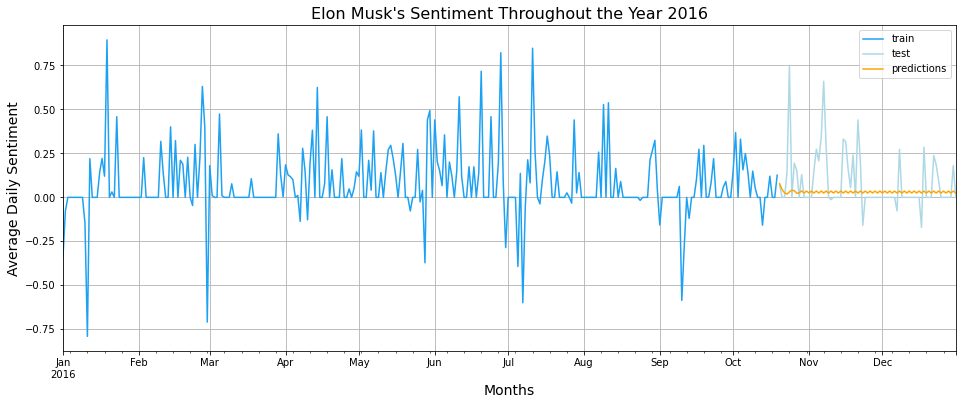

In [45]:
fig, ax = plt.subplots(figsize=(16, 6))
data_train['Sentiment'].plot(ax=ax, label='train', color="#1DA1F2")
data_test['Sentiment'].plot(ax=ax, label='test', color="LightBlue")
predictions.plot(ax=ax, label='predictions', color="Orange")
plt.title("Elon Musk's Sentiment Throughout the Year 2016", fontsize=16)
plt.xlabel("Months", fontsize=14)
plt.ylabel("Average Daily Sentiment", fontsize = 14)
plt.grid(True)
ax.legend();

My original model is the only one to get a MSE close to 0.03. I will just use that one for predictions

# 2.6 Prediction

In [51]:
forecaster = ForecasterAutoreg(
regressor=RandomForestRegressor(random_state=123),
lags=6)
forecaster.fit(y=data_train["Sentiment"])
forecaster
predictions = forecaster.predict(steps=steps+90)
predictions.tail()

2017-03-27   -0.023919
2017-03-28    0.079154
2017-03-29   -0.149958
2017-03-30   -0.201116
2017-03-31    0.027756
Freq: D, Name: pred, dtype: float64

In [52]:
predictions

2016-10-20    0.121193
2016-10-21    0.163981
2016-10-22    0.106451
2016-10-23    0.171392
2016-10-24    0.114855
                ...   
2017-03-27   -0.023919
2017-03-28    0.079154
2017-03-29   -0.149958
2017-03-30   -0.201116
2017-03-31    0.027756
Freq: D, Name: pred, Length: 163, dtype: float64

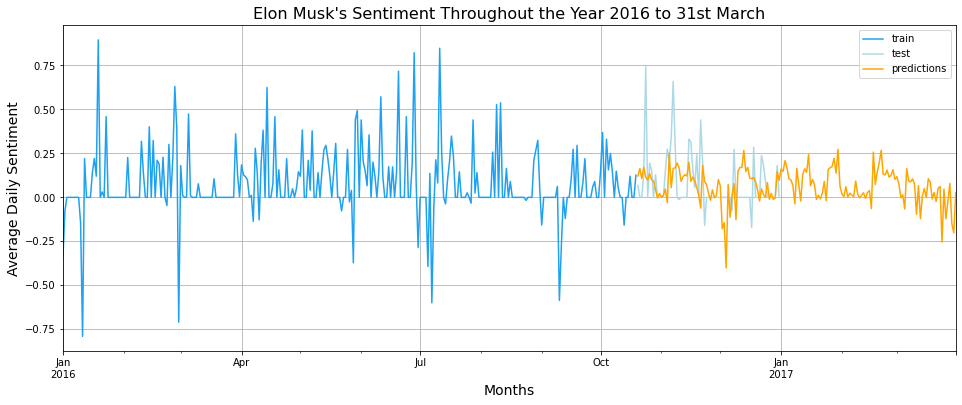

In [53]:
fig, ax = plt.subplots(figsize=(16, 6))
data_train['Sentiment'].plot(ax=ax, label='train', color="#1DA1F2")
data_test['Sentiment'].plot(ax=ax, label='test', color="LightBlue")
predictions.plot(ax=ax, label='predictions', color="Orange")
plt.title("Elon Musk's Sentiment Throughout the Year 2016 to 31st March", fontsize=16)
plt.xlabel("Months", fontsize=14)
plt.ylabel("Average Daily Sentiment", fontsize = 14)
plt.grid(True)
ax.legend();

In [87]:
weekly = predictions[steps:80] 

In [88]:
weekly

2017-01-01    0.161817
2017-01-02    0.147649
2017-01-03    0.208974
2017-01-04    0.166857
2017-01-05    0.105912
2017-01-06    0.098613
2017-01-07    0.068333
Freq: D, Name: pred, dtype: float64

In [81]:
monthly = predictions[steps:104]

In [82]:
monthly

2017-01-01    0.161817
2017-01-02    0.147649
2017-01-03    0.208974
2017-01-04    0.166857
2017-01-05    0.105912
2017-01-06    0.098613
2017-01-07    0.068333
2017-01-08   -0.036477
2017-01-09    0.164785
2017-01-10    0.074022
2017-01-11   -0.021354
2017-01-12    0.129124
2017-01-13    0.162299
2017-01-14    0.142824
2017-01-15    0.243214
2017-01-16    0.066463
2017-01-17    0.102083
2017-01-18    0.073434
2017-01-19   -0.011709
2017-01-20    0.011768
2017-01-21   -0.009075
2017-01-22    0.023335
2017-01-23    0.090843
2017-01-24   -0.018630
2017-01-25    0.158883
2017-01-26    0.168567
2017-01-27    0.175953
2017-01-28    0.222297
2017-01-29    0.137823
2017-01-30    0.273143
2017-01-31    0.063521
Freq: D, Name: pred, dtype: float64

In [83]:
threeMonth = predictions[steps:]

In [84]:
threeMonth

2017-01-01    0.161817
2017-01-02    0.147649
2017-01-03    0.208974
2017-01-04    0.166857
2017-01-05    0.105912
                ...   
2017-03-27   -0.023919
2017-03-28    0.079154
2017-03-29   -0.149958
2017-03-30   -0.201116
2017-03-31    0.027756
Freq: D, Name: pred, Length: 90, dtype: float64

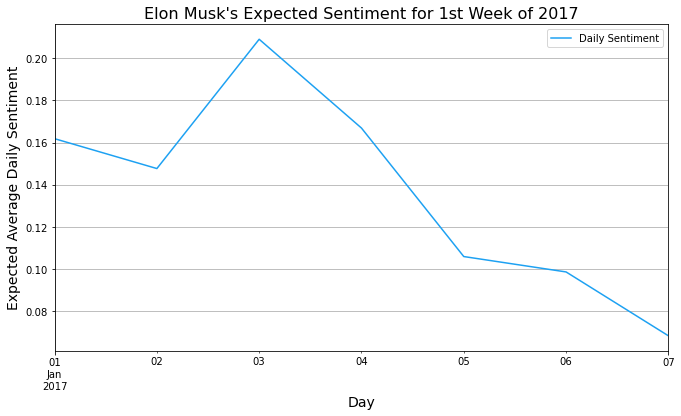

In [94]:
fig, ax = plt.subplots(figsize=(11, 6))
weekly.plot(ax=ax, label='Daily Sentiment', color="#1DA1F2")
plt.title("Elon Musk's Expected Sentiment for 1st Week of 2017", fontsize=16)
plt.xlabel("Day", fontsize=14)
plt.ylabel("Expected Average Daily Sentiment", fontsize = 14)
plt.grid(True)
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
weekly.plot(ax=ax, label='Daily Sentiment', color="#1DA1F2")
plt.title("Elon Musk's Expected Sentiment for 1st Week of 2017", fontsize=16)
plt.xlabel("Day", fontsize=14)
plt.ylabel("Expected Average Daily Sentiment", fontsize = 14)
plt.grid(True)
ax.legend();

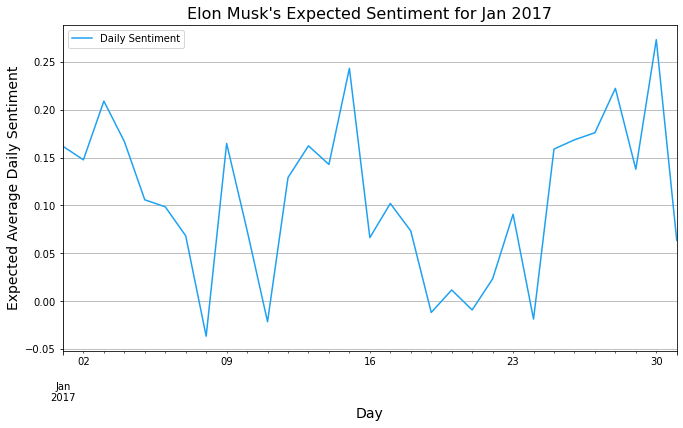

In [95]:
fig, ax = plt.subplots(figsize=(11, 6))
monthly.plot(ax=ax, label='Daily Sentiment', color="#1DA1F2")
plt.title("Elon Musk's Expected Sentiment for Jan 2017", fontsize=16)
plt.xlabel("Day", fontsize=14)
plt.ylabel("Expected Average Daily Sentiment", fontsize = 14)
plt.grid(True)
ax.legend();

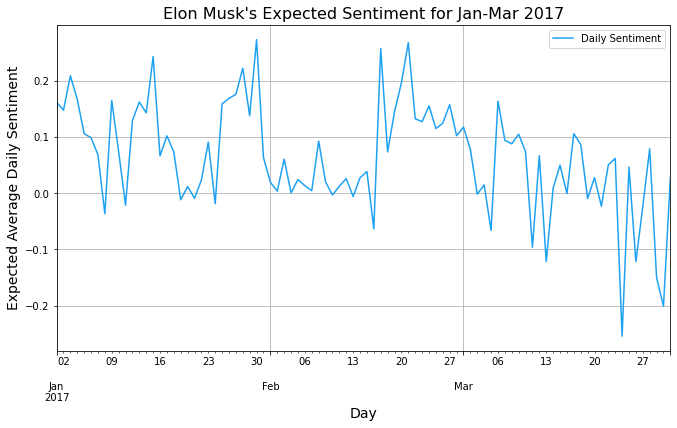

In [96]:
fig, ax = plt.subplots(figsize=(11, 6))
threeMonth.plot(ax=ax, label='Daily Sentiment', color="#1DA1F2")
plt.title("Elon Musk's Expected Sentiment for Jan-Mar 2017", fontsize=16)
plt.xlabel("Day", fontsize=14)
plt.ylabel("Expected Average Daily Sentiment", fontsize = 14)
plt.grid(True)
ax.legend();

In [104]:
threeMonth.to_csv('TimeSeries.csv')

# 2.7 Interactive Dashboard
Not finished nor do I understand it. But it kinda works

In [156]:
df = pd.read_csv("TimeSeries.csv")

In [157]:
df.head()

,Unnamed: 0,pred
0,2017-01-01,0.161817
1,2017-01-02,0.147649
2,2017-01-03,0.208974
3,2017-01-04,0.166857
4,2017-01-05,0.105912


In [158]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [159]:
df=df.rename(columns={"Unnamed: 0":"Date"}) #Rename column
df["Date"]=pd.to_datetime(df["Date"],format="%Y/%m/%d")#Change to datetime

In [160]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02, subplot_titles=("Time Series", "Scroll Bar"))

In [161]:
fig.add_trace(go.Scatter(x=df['Date'], y=df['pred'], name='Prediction'), row=1, col=1)

In [162]:
fig.update_xaxes(
    rangeslider=dict(visible=True),
    rangeselector=dict(
        buttons=list([
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="todate"),
            dict(step="all")
        ])
    ),
    row=2, col=1
)

# Show the figure
fig.show()

In [163]:
fig.update_layout(height=600, title_text="Interactive Time Series Dashboard")

Broke when I tried to do what I wanted to do so I edited it out.

In [164]:
#layout = go.Layout(
    #title="Your Graph Title",
    #xaxis=dict(title="X Axis Title"),
    #yaxis=dict(title="Y Axis Title"),
    #updatemenus=[
        #dict(
            #buttons=[
            #dict(count=7, label="1w", step="day", stepmode="backward"),
            #dict(count=1, label="1m", step="month", stepmode="backward"),
            #dict(count=3, label="3m", step="month", stepmode="todate"),
           # dict(step="all")
           # ],
           # direction="down",
           # showactive=True,
           # xanchor="left",
           # yanchor="top",
           # x=0,
           # y=1.2
       # ),
   # ]
#)
#
#fig = go.Figure(data=df, layout=layout)
#fig.show()

# 2.8 References

https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html <br>
https://plotly.com/python/range-slider/<br>
https://plotly.com/python/time-series/